In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) --> This is incorrect line and hence commented
    transforms.Normalize((0.1307,), (0.3081,))
    ])

See how to get separate validations dataset

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [5]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.mnist.MNIST,
 60000,
 2,
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [6]:
batch_size = 128

#kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} --> Commented the incorrect line. shuffle parameter needs to be True
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(train_data, **kwargs) --> Commented the incorrect line. test_data needs be passed for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

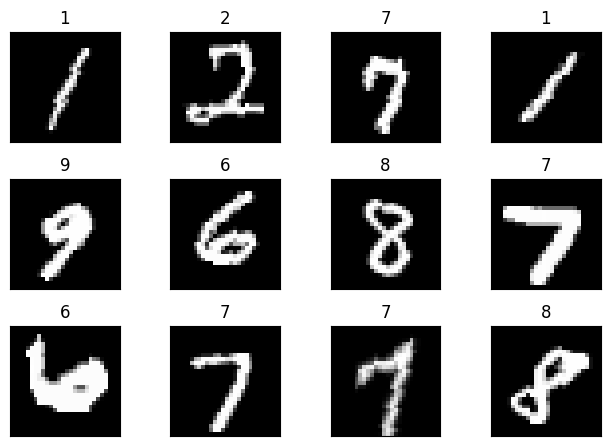

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, 3, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Conv2d(32, 32, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.Conv2d(32, 32, 3, stride=2, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        ) # 26*26*16
        
        self.trans1 = nn.Sequential(
            nn.Conv2d(128, 8, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Conv2d(64, 64, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d(64, 64, 3, stride=2, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            #nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        ) # 24*24*32 | 12*12*32

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Conv2d(64, 64, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d(64, 64, 3, stride=2, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, 2)            
        ) # 24*24*32 | 12*12*32
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1), # 1*1 convolution
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        ) # 10*10*32 | 5*5*32

        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # 1*1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, 2)            
        ) # 5*5*32

        self.trans2 = nn.Sequential(
            nn.Conv2d(32, 16, 1, padding=1)
            #nn.ReLU(),
            #nn.BatchNorm2d(4),
            # nn.Conv2d(64, 64, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d(64, 64, 3, stride=2, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            #nn.MaxPool2d(2, 2),
            #nn.Dropout(0.1)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1), # 1*1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
            #nn.MaxPool2d(2, 2)            
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # 1*1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1)
            #nn.MaxPool2d(2, 2)            
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=1), # 1*1
            #nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.Dropout(0.1)
            nn.AvgPool2d(kernel_size=7)            
        )

        # self.fc1 = nn.Sequential(
        #     nn.Linear(800, 10)
        # )

        # self.fc2 = nn.Sequential(
        #     nn.Linear(50, 10)
        # )

        #to be checked
        #self.GovalAvgPooling = nn.AdaptiveAvgPool1d(10)

        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3) # 26*26*32
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 24*24*64 | 12*12*64
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 10*10*128
        # self.conv4 = nn.Conv2d(128, 256, kernel_size=3) # 8*8*256 | 4*4*256
        # #self.fc1 = nn.Linear(320, 50) --> This is incorrect shape hence commented.
        # self.fc1 = nn.Linear(4096, 50)
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
      x = self.conv1(x)
      #print("size after 1st layer: " ,x.shape)
      x = self.trans1(x)
      x = self.conv2(x)
      #print("size after 2nd layer: " ,x.shape)
      x = self.conv3(x)
      #print("size after 3rd layer: " ,x.shape)
      x = self.conv4(x)
      x = self.trans2(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.conv7(x)
      #print("size after 4th layer: " ,x.shape)
        
      x = x.view(x.size(0), -1)
      #print("size after flattening: " ,x.shape)
      #x = self.fc1(x)
      #x = self.fc2(x)
      x = F.log_softmax(x, dim=1)
      return x
        # x = F.relu(self.conv1(x),2)
        # #print("size after 1st layer: " ,x.shape)
        # x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # #print("size after 2nd layer and max pooling: " ,x.shape)
        # x = F.relu(self.conv3(x), 2)
        # #print("size after 3rd layer: " ,x.shape)
        # x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        # #print("size after 4th layer and max pooling: " ,x.shape)
        # #x = x.view(-1, 320)
        # x = x.view(-1, 4096)
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        # return F.log_softmax(x, dim=1)

In [9]:
from tqdm import tqdm

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [12]:
def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    #loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

In [13]:
def test(model, device, test_loader,criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
       BatchNorm2d-3          [-1, 128, 28, 28]             256
           Dropout-4          [-1, 128, 28, 28]               0
            Conv2d-5            [-1, 8, 30, 30]           1,032
              ReLU-6            [-1, 8, 30, 30]               0
       BatchNorm2d-7            [-1, 8, 30, 30]              16
           Dropout-8            [-1, 8, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]           1,168
             ReLU-10           [-1, 16, 30, 30]               0
      BatchNorm2d-11           [-1, 16, 30, 30]              32
          Dropout-12           [-1, 16, 30, 30]               0
        MaxPool2d-13           [-1, 16, 15, 15]               0
           Conv2d-14           [-1, 16,

In [17]:
model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9) -- Commented the line since learning rate needs to be corrected
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  #test(model, device, train_loader) --> Removed this incorrect line. test_loader needs to be passed here
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2389 Batch_id=468 Accuracy=81.62: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Test set: Average loss: 0.1163, Accuracy: 9704/10000 (97.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0471 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Test set: Average loss: 0.0754, Accuracy: 9786/10000 (97.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0212 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]


Test set: Average loss: 0.0445, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0512 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:30<00:00, 15.56it/s]


Test set: Average loss: 0.0401, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0374 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s]


Test set: Average loss: 0.0289, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0505 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Test set: Average loss: 0.0327, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0571 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]


Test set: Average loss: 0.0295, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0406 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Test set: Average loss: 0.0289, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0964 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Test set: Average loss: 0.0256, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0175 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:30<00:00, 15.44it/s]


Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0337 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0672 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0298 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0259 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0305 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]


Test set: Average loss: 0.0246, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0749 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:28<00:00, 16.22it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0200 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:28<00:00, 16.31it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0370 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]


Test set: Average loss: 0.0175, Accuracy: 9950/10000 (99.50%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0988 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Test set: Average loss: 0.0186, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0185 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:30<00:00, 15.43it/s]


Test set: Average loss: 0.0176, Accuracy: 9950/10000 (99.50%)

Adjusting learning rate of group 0 to 1.0000e-03.


In [18]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

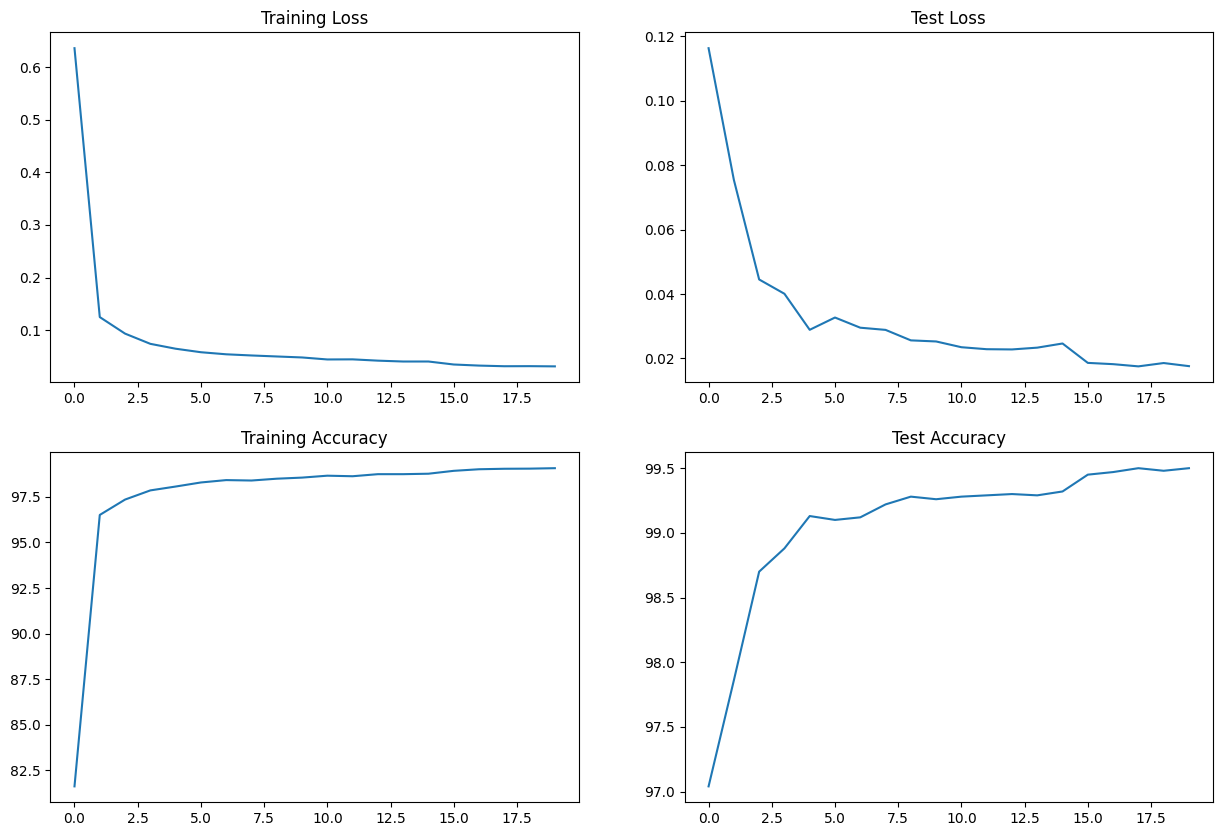

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")